# **Regression using bagging on decision trees**

In [1]:
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
class Node:
    def __init__(
        self,
        split_feature_index=None,
        split_treshhold=None,
        left_subtree=None,
        right_subtree=None,
        node_variance_reduction=None,
        leaf_node_value=None,
    ):
        self.split_feature_index = split_feature_index
        self.split_treshhold = split_treshhold
        self.left_subtree = left_subtree
        self.right_subtree = right_subtree
        self.node_variance_reduction = node_variance_reduction

        self.leaf_node_value = leaf_node_value

In [3]:
class Decision_tree_regression:
    def __init__(self, node_min_samples_quant=2, max_depth=2):
        self._node_min_samples_quant = node_min_samples_quant
        self._max_depth = max_depth

        self._root = None

    def fit(self, X, Y):
        dataset = np.concatenate((X, Y), axis=1, dtype=object)
        self._root = self._build_tree(dataset)

    def _build_tree(self, dataset, current_depth=0):
        X = dataset[:, :-1]
        Y = dataset[:, -1]

        dataset_rows_quant, dataset_features_quant = X.shape

        if (
            dataset_rows_quant >= self._node_min_samples_quant
            and current_depth <= self._max_depth
        ):
            best_split_values = self._get_best_split(dataset, dataset_features_quant)
            
            if best_split_values != {}:
                if best_split_values["node_variance_reduction"] > 0:
                    left_subtree = self._build_tree(
                        best_split_values["dataset_left_split"], current_depth + 1
                    )
                    right_subtree = self._build_tree(
                        best_split_values["dataset_right_split"], current_depth + 1
                    )

                    return Node(
                        best_split_values["split_feature_index"],
                        best_split_values["split_treshhold"],
                        left_subtree,
                        right_subtree,
                        best_split_values["node_variance_reduction"],
                    )

        leaf_node_value = self._calculate_leaf_node_value(Y)

        return Node(leaf_node_value=leaf_node_value)

    def _get_best_split(self, dataset, dataset_features_quant):
        max_variance_reduction = -float("inf")
        best_split_values = {}

        for current_split_feature_idx in range(dataset_features_quant):
            possible_treshholds = np.unique(dataset[:, current_split_feature_idx])

            for current_split_treshhold in possible_treshholds:
                dataset_left_split, dataset_right_split = self._make_split(
                    dataset, current_split_feature_idx, current_split_treshhold
                )

                if len(dataset_left_split) > 0 and len(dataset_right_split) > 0:
                    current_variance_reduction = self._calculate_variance_reduction(
                        dataset, dataset_left_split, dataset_right_split
                    )

                    if current_variance_reduction > max_variance_reduction:
                        best_split_values["split_feature_index"] = current_split_feature_idx
                        best_split_values["split_treshhold"] = current_split_treshhold
                        best_split_values["dataset_left_split"] = dataset_left_split
                        best_split_values["dataset_right_split"] = dataset_right_split
                        best_split_values["node_variance_reduction"] = current_variance_reduction
                        max_variance_reduction = current_variance_reduction

        return best_split_values

    def _make_split(
        self, dataset, dataset_split_feature_index, dataset_split_treshhold
    ):
        dataset_left_split = np.array(
            [
                row
                for row in dataset
                if row[dataset_split_feature_index] <= dataset_split_treshhold
            ]
        )
        dataset_right_split = np.array(
            [
                row
                for row in dataset
                if row[dataset_split_feature_index] > dataset_split_treshhold
            ]
        )

        return dataset_left_split, dataset_right_split

    def _calculate_variance_reduction(
        self, dataset, dataset_left_split, dataset_right_split
    ):
        dataset_targets = dataset[:, -1]
        dataset_left_split_targets = dataset_left_split[:, -1]
        dataset_right_split_targets = dataset_right_split[:, -1]

        card_dataset_left_split = len(dataset_left_split)
        card_dataset_right_split = len(dataset_right_split)
        card_dataset = len(dataset_targets)

        dataset_left_split_targets_variance = np.var(dataset_left_split_targets)
        dataset_right_split_targets_variance = np.var(dataset_right_split_targets)
        dataset_targets_variance = np.var(dataset_targets)

        dataset_variance = card_dataset * dataset_targets_variance
        split_variance = (
            card_dataset_left_split * dataset_left_split_targets_variance
            + card_dataset_right_split * dataset_right_split_targets_variance
        )

        variance_reduction = dataset_variance - split_variance

        return variance_reduction

    def _calculate_leaf_node_value(self, dataset_targets):
        return np.mean(dataset_targets)

    def predict(self, data):
        predictions = np.array(
            [self._make_prediction(data_sample, self._root) for data_sample in data]
        )

        return predictions.reshape(-1, 1)

    def _make_prediction(self, sample, current_node):
        if current_node.leaf_node_value != None:
            return current_node.leaf_node_value
        else:
            feature_value = sample[current_node.split_feature_index]

            if feature_value <= current_node.split_treshhold:
                return self._make_prediction(sample, current_node.left_subtree)
            else:
                return self._make_prediction(sample, current_node.right_subtree)

In [4]:
class Decision_trees_bagging:
    def __init__(
        self,
        tree_node_min_samples_quant=2,
        trees_max_depth=2,
        trees_count=10,
        bootstrap_set_size=10,
    ):
        self._tree_node_min_samples_quant = tree_node_min_samples_quant
        self._trees_max_depth = trees_max_depth
        self._trees_count = trees_count
        self._subset_size = bootstrap_set_size
        self._dataset_subsets = []
        self._decision_trees_base_algorithms = []

    def fit(self, X, Y):
        dataset = np.concatenate((X, Y), axis=1, dtype=object)

        self._dataset_subsets = self._make_subsets(
            dataset, self._trees_count, self._subset_size
        )

        # This loop train our self._trees_count decision trees, using all of self._dataset_subsets
        for dataset_subset in self._dataset_subsets:
            subset_X = dataset_subset[:, :-1]
            subset_Y = dataset_subset[:, -1].reshape(-1, 1)

            model = Decision_tree_regression(
                node_min_samples_quant=self._tree_node_min_samples_quant,
                max_depth=self._trees_max_depth,
            )
            model.fit(subset_X, subset_Y)

            # Now we need to save our model on self._decision_trees_base_algorithms list
            self._decision_trees_base_algorithms.append(model)

    def _make_subsets(
        self, dataset, subsets_quant, subset_size
    ):
        dataset_subsets = []

        for i in range(subsets_quant):
            dataset_subsets.append(
                self._make_subset(dataset, subset_size)
            )

        return dataset_subsets

    def _make_subset(self, dataset, subset_size):
        dataset_subset = np.array(
            random.sample(list(dataset), subset_size)
        )

        return dataset_subset

    def predict(self, X):
        predictions = []

        for base_algorithm in self._decision_trees_base_algorithms:
            predictions.append(base_algorithm.predict(X).reshape(1, -1))

        predictions = np.transpose(predictions)

        main_preditions = [
            np.mean(prediction) for prediction in predictions
        ]

        return np.array(main_preditions).reshape(-1, 1)

In [5]:
input_data_path = "D://admp_northallerton/my_machine_learning/datasets/regression_dataset.csv"
df = pd.read_csv(input_data_path)
df

,x,x**2,x**4,x**6,y
0,9.654847,93.216070,8689.235643,8.099764e+05,-2.201737
1,-4.302651,18.512806,342.723979,6.344782e+03,-3.946500
2,-6.088928,37.075048,1374.559199,5.096185e+04,-1.175392
3,7.098774,50.392586,2539.412754,1.279676e+05,5.168823
4,0.712728,0.507981,0.258045,1.310819e-01,0.466053
...,...,...,...,...,...
495,4.912969,24.137265,582.607542,1.406255e+04,-4.814470
496,-0.040203,0.001616,0.000003,4.222620e-09,0.001616
497,8.668111,75.136146,5645.440420,4.241766e+05,5.950674
498,-7.927589,62.846674,3949.704434,2.482258e+05,7.906123


In [6]:
X = df.iloc[:, :-1].values
Y = df.iloc[:, -1].values.reshape(-1, 1)

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.4, random_state=42
)

In [8]:
model = Decision_trees_bagging(
    tree_node_min_samples_quant=2,
    trees_max_depth=20,
    trees_count=60,
    bootstrap_set_size=42,
)
model.fit(X_train, Y_train)

In [9]:
Y_pred = model.predict(X_test)

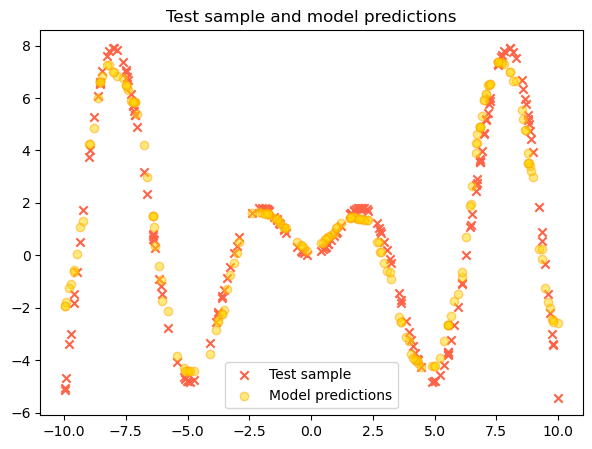

In [10]:
graph_X_values = X_test[:, 0]
graph_Y_test_values = Y_test
graph_Y_pred_values = Y_pred

figure, ax = plt.subplots()

figure.set_figwidth(7)
figure.set_figheight(5)

ax.set_title("Test sample and model predictions")

ax.scatter(
    graph_X_values, graph_Y_test_values, color="tomato", label="Test sample", marker="x"
)
ax.scatter(
    graph_X_values,
    graph_Y_pred_values,
    color="gold",
    edgecolors="orange",
    label="Model predictions",
    alpha=0.5,
)

ax.legend()

plt.show()

In [11]:
mean_squared_error_value = mean_squared_error(Y_test, Y_pred)
mean_squared_error_value

0.6902485973389203

In [12]:
test_df = pd.DataFrame(
    np.concatenate((X_test, Y_test), axis=1), columns=["x", "x**3", "x**5", "x**7", "y"]
)
test_df.head()

,x,x**3,x**5,x**7,y
0,-5.780891,33.418703,1116.809713,37322.332150,-2.783138
1,8.698559,75.664930,5725.181628,433195.467026,5.776255
2,-8.992479,80.864680,6539.096433,528781.939023,3.767483
3,5.397147,29.129200,848.510296,24716.426149,-4.180479
4,-6.381836,40.727831,1658.756192,67557.541336,0.628552


In [13]:
pred_df = pd.DataFrame(
    np.concatenate((X_test, Y_pred), axis=1), columns=["x", "x**3", "x**5", "x**7", "y"]
)
pred_df.head()

,x,x**3,x**5,x**7,y
0,-5.780891,33.418703,1116.809713,37322.332150,-2.102985
1,8.698559,75.664930,5725.181628,433195.467026,4.791915
2,-8.992479,80.864680,6539.096433,528781.939023,4.239683
3,5.397147,29.129200,848.510296,24716.426149,-3.268363
4,-6.381836,40.727831,1658.756192,67557.541336,1.499216
